In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from src.utils import load, clean_data
from src.preprocessing import DataSet
from src.forecast import TSCV, CLSTM, CLSTMModel
from src.utils import GridSearch
from src.ploting import LinearPlot

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:

CURR = "EURUSD"
INTERVAL = "4h"

eurusd = load(currency=CURR, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().get_tvt_df()

# Construct LSTM part

In [32]:
from src.forecast.lstm import LSTM_

In [34]:
model = LSTM_(
    activation='tanh',
    target_col='target_value'
)
model.compile()
model.fit(train,
          epochs=10,
          steps_per_epoch=100)

ValueError: Exception encountered when calling layer 'sequential_8' (type Sequential).

Input 0 of layer "lstm_25" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (128, 64)

Call arguments received by layer 'sequential_8' (type Sequential):
  • inputs=tf.Tensor(shape=(128, 10, 49), dtype=float32)
  • training=False
  • mask=None

In [6]:
pred_y = model.predict(test)

48/48 [==============================] - 2s 18ms/step


# Construct CNN part

In [22]:
from src.forecast.cnn import CNN_

In [25]:
model = CNN_(
    activation="selu"
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model.fit(train,
          epochs=5,
          steps_per_epoch=100)

KeyError: "None of [Index(['target_direction'], dtype='object')] are in the [index]"

In [518]:
pred = model.predict(test)
res = pd.DataFrame({"pred": pred, "true": test.target_direction[10:]})
res

 1/48 [..............................] - ETA: 13s

2023-05-06 15:24:20.009131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 9ms/step


,pred,true
Datetime,,
2021-11-09 04:00:00,0,0
2021-11-09 08:00:00,0,0
2021-11-09 12:00:00,0,0
2021-11-09 16:00:00,0,0
2021-11-10 00:00:00,0,1
...,...,...
2022-10-17 12:00:00,0,0
2022-10-17 16:00:00,0,0
2022-10-17 20:00:00,0,0


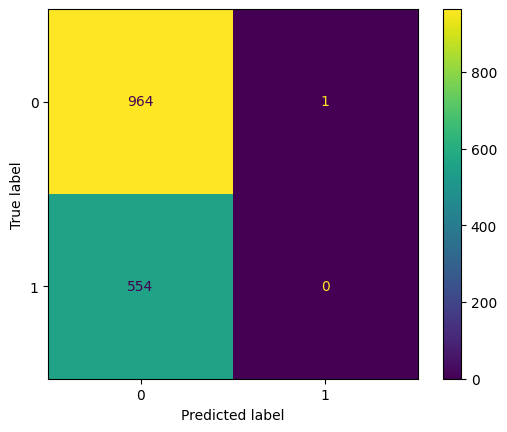

In [519]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(res.true, res.pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()

# Combine both, train and evalute

In [25]:
# model = CLSTMModel(
#     nodes=[64, 32],
#     lstm_nodes=[16, 32, 32, 32],
#     lstm_activation='selu',
#     cnn_filters=4,
#     cnn_kernel_size=4,
#     cnn_activation='selu',
#     activation='selu',
#     seq_len=20
# )
# model.compile()
model.fit(
    data=train,
    epochs=30,
    steps_per_epoch=100,
)

Epoch 1/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6870 - root_mean_squared_error: 0.0157
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.6726 - root_mean_squared_error: 0.0156
New lowest loss: 0.6726
100/100 [==============================] - 7s 68ms/step - loss: 0.6726 - root_mean_squared_error: 0.0156
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.6689 - root_mean_squared_error: 0.0156
New lowest loss: 0.6689
100/100 [==============================] - 7s 68ms/step - loss: 0.6689 - root_mean_squared_error: 0.0156
Epoch 4/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6773 - root_mean_squared_error: 0.0156
Epoch 5/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6832 - root_mean_squared_error: 0.0157
Epoch 6/30
100/100 [==============================] - 7s 71ms/step - loss: 0.6720 - root_mean_squared_error: 0.0156
Epoch 7/30
100/100 [==============================] - 7s

In [36]:
pred_y = model.predict(test)

48/48 [==============================] - 4s 33ms/step


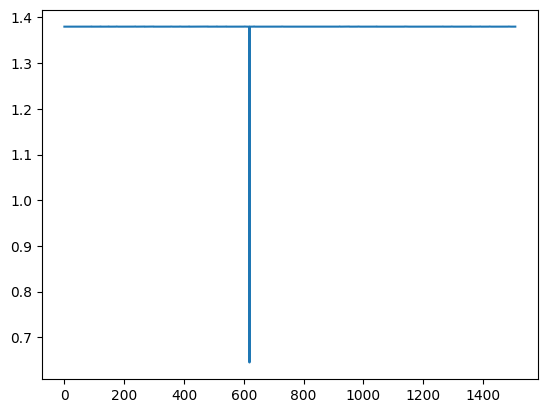

In [37]:
plt.plot(pred_y)

In [39]:
best_mod = CLSTMModel.load(path='best')

In [53]:
best_mod.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.01,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

# Timeseries CrossValidation for CLSTM

In [11]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=20)

# provide model and all necessary params
tscv.run(CLSTM())

split: 1/3
lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
[32, 64] selu
Epoch 1/10
50/50 [==============================] - 8s 67ms/step - loss: 1.0777 - root_mean_squared_error: 1.4152
Epoch 2/10
50/50 [==============================] - 3s 65ms/step - loss: 0.5993 - root_mean_squared_error: 0.6825
Epoch 3/10
50/50 [==============================] - 3s 68ms/step - loss: 0.2117 - root_mean_squared_error: 0.3168
Epoch 4/10
50/50 [==============================] - 3s 66ms/step - loss: 0.0514 - root_mean_squared_error: 0.1151
Epoch 5/10
50/50 [==============================] - 3s 66ms/step - loss: 0.0332 - root_mean_squared_error: 0.0874
Epoch 6/10
50/50 [==============================] - 3s 67ms/step - loss: 0.0241 - root_mean_squared_error: 0.0731
Epoch 7/10
50/50 [==============================] - 3s 66ms/step - loss: 0.0201 - root_mean_squared_error: 0.0662
Epoch 8/10
50/50 [==============================] - 3s 66ms/step - loss: 0.0153 - root_mean_squared_error: 0.0626
Epoch 

({'mean_absolute_percentage_error': 0.16244224,
  'rmspe': 0.19560337,
  'mean_absolute_error': 0.19108066},
 {'mean_absolute_percentage_error': 0.20126007,
  'rmspe': 0.20275256,
  'mean_absolute_error': 0.19656907})

In [29]:
bestest = CLSTM().load(path="best")

lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
[32, 64] selu
Loading model: loss_0.0007.h5..


In [24]:
# fine tuning last layers
tscv.run(bestest)

split: 1/3
Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0038
New lowest loss: 0.0022
50/50 [==============================] - 10s 107ms/step - loss: 0.0022 - root_mean_squared_error: 0.0038
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0022
New lowest loss: 0.0016
50/50 [==============================] - 3s 67ms/step - loss: 0.0016 - root_mean_squared_error: 0.0022
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 7.4338e-04 - root_mean_squared_error: 9.8708e-04
New lowest loss: 0.0007
50/50 [==============================] - 3s 66ms/step - loss: 7.4338e-04 - root_mean_squared_error: 9.8708e-04
Epoch 4/10
50/50 [==============================] - 3s 64ms/step - loss: 9.0100e-04 - root_mean_squared_error: 0.0012
Epoch 5/10
50/50 [==============================] - 3s 64ms/step - loss: 9.0215e-04 - root_mean_squared_error: 0.0011
Epoch 6/10
50/50 [=========

({'mean_absolute_percentage_error': 0.17875786,
  'rmspe': 0.20220633,
  'mean_absolute_error': 0.20269303},
 {'mean_absolute_percentage_error': 0.39919028,
  'rmspe': 0.3992366,
  'mean_absolute_error': 0.38996497})

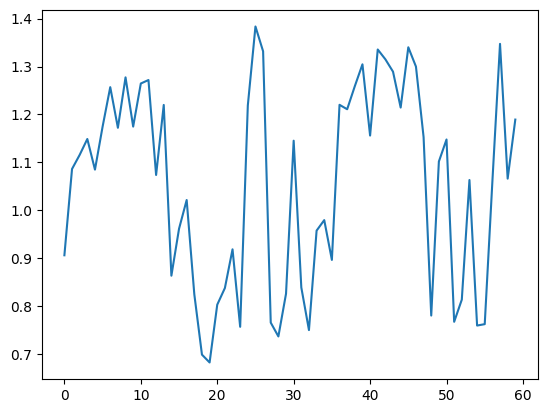

In [12]:
plt.plot(tscv.predicted)

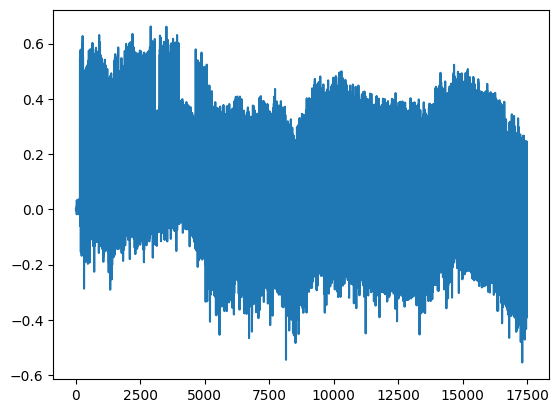

In [13]:
plt.plot(tscv.residuals)

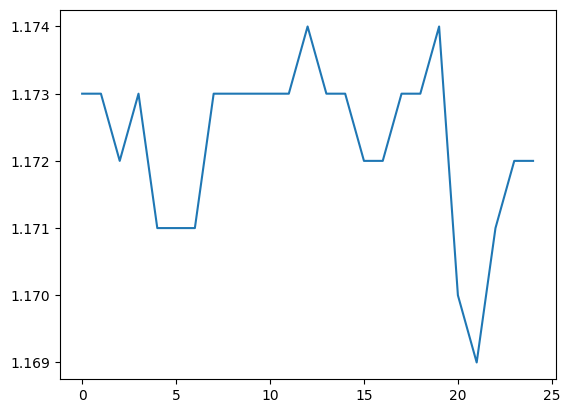

In [26]:
plt.plot(train.Close.values[-25:])

In [12]:
best_mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 49, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 49, 8)    520         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 24, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 input_1 (InputLayer)           [(128, 30, 49)]      0           []                               
                                                                                              

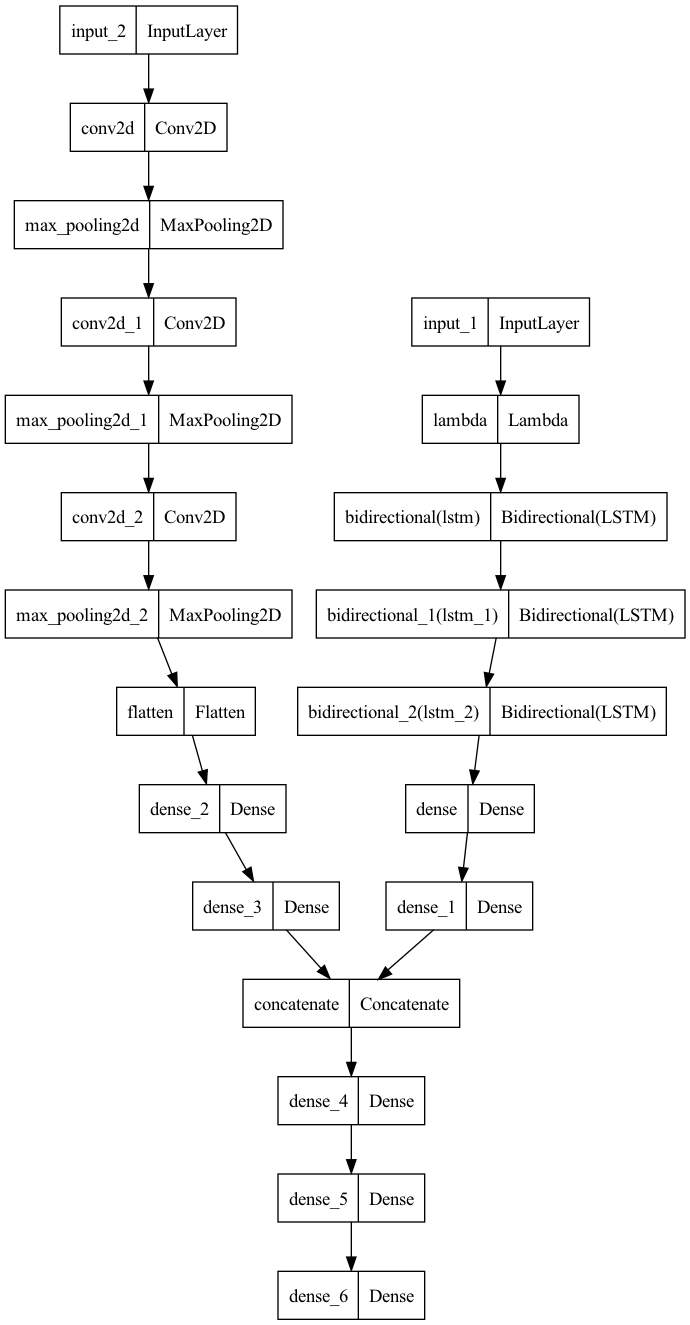

In [38]:
from keras.utils import plot_model
plot_model(bestest.model, to_file="best_model.png")

# GridSearch best params

### GridSearch for LSTM part

In [5]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=4,
            test_size=120)

gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                # params={'lstm_activatation': ['selu', 'relu', 'tanh'],
                #         'lstm_nodes': [[32, 16, 16, 16],
                #                   [64, 32, 32, 32],
                #                   [128, 64, 64, 64],
                #                   [16, 32, 64, 128]],
                #         'seq_len': [10, 20, 30]},
                params={'lstm_activatation': ['tanh'],
                        'lstm_nodes': [[16, 32, 64, 128]],
                        'seq_len': [30]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
gs.run()

split: 1/4
lstm_kwargs: {'activatation': 'tanh', 'nodes': [16, 32, 64, 128], 'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
Epoch 1/10
50/50 [==============================] - 7s 68ms/step - loss: 86.8964 - root_mean_squared_error: 1.2185
Epoch 2/10
50/50 [==============================] - 3s 65ms/step - loss: 37.6962 - root_mean_squared_error: 0.5842
Epoch 3/10
50/50 [==============================] - 3s 65ms/step - loss: 1.4345 - root_mean_squared_error: 0.0266
Epoch 4/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7757 - root_mean_squared_error: 0.0148
Epoch 5/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7715 - root_mean_squared_error: 0.0148
Epoch 6/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7706 - root_mean_squared_error: 0.0148
Epoch 7/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7697 - root_mean_squared_error: 0.0148
Epoch 8/10
50/50 [==============================] - 3s 64ms/step - loss: 0.7688 

### GridSearch for CNN part

In [3]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=4,
            test_size=120)

# pool_size = 
gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                params={'cnn_activatation': ['selu', 'relu', 'tanh'],
                        'cnn_filters': [4, 8, 16],
                        'cnn_kernel_size': [2, 4, 8],
                        'cnn_pool_size': [2],
                        'seq_len': [30]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
# gs.run()

# pool_size = 3
gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                params={'cnn_activatation': ['selu', 'relu', 'tanh'],
                        'cnn_filters': [4, 8, 16],
                        'cnn_kernel_size': [2, 4, 8],
                        'cnn_pool_size': [3],
                        'seq_len': [30]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
gs.run()

split: 1/4
lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'activatation': 'tanh', 'filters': 4, 'kernel_size': 2, 'pool_size': 3, 'seq_len': 30}
Epoch 1/10
50/50 [==============================] - 7s 68ms/step - loss: 88.7206 - root_mean_squared_error: 1.2320
Epoch 2/10
50/50 [==============================] - 3s 65ms/step - loss: 51.7618 - root_mean_squared_error: 0.7316
Epoch 3/10
50/50 [==============================] - 3s 66ms/step - loss: 14.9469 - root_mean_squared_error: 0.2486
Epoch 4/10
50/50 [==============================] - 3s 66ms/step - loss: 1.0753 - root_mean_squared_error: 0.0195
Epoch 5/10
50/50 [==============================] - 3s 66ms/step - loss: 0.7745 - root_mean_squared_error: 0.0148
Epoch 6/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7731 - root_mean_squared_error: 0.0149
Epoch 7/10
50/50 [==============================] - 3s 68ms/step - loss: 0.7731 - root_mean_squared_error: 0.0149
Epoch 8/10
50/50 [==============================] - 3s 66ms

### GridSearch for following Dense-layers part

In [10]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=4,
            test_size=120)

gs = GridSearch(model_class=CLSTM,
                tscv=tscv,
                params={'activation': ['tanh', 'selu', 'relu'],
                        'nodes': [[32, 16],
                                  [64, 32],
                                  [128, 64],
                                  [16, 32],
                                  [32, 64]],
                        'seq_len': [30]},
                by=['mean_absolute_percentage_error'],
                p_count=None)
gs.run()

split: 1/4
lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
[32, 16] tanh
Epoch 1/10
50/50 [==============================] - 7s 65ms/step - loss: 89.3853 - root_mean_squared_error: 1.2511
Epoch 2/10
50/50 [==============================] - 3s 64ms/step - loss: 55.3379 - root_mean_squared_error: 0.7720
Epoch 3/10
50/50 [==============================] - 3s 65ms/step - loss: 30.1424 - root_mean_squared_error: 0.4281
Epoch 4/10
50/50 [==============================] - 3s 65ms/step - loss: 7.0141 - root_mean_squared_error: 0.1244
Epoch 5/10
50/50 [==============================] - 3s 63ms/step - loss: 0.8210 - root_mean_squared_error: 0.0154
Epoch 6/10
50/50 [==============================] - 3s 64ms/step - loss: 0.7714 - root_mean_squared_error: 0.0148
Epoch 7/10
50/50 [==============================] - 3s 65ms/step - loss: 0.7708 - root_mean_squared_error: 0.0148
Epoch 8/10
24/50 [=============>................] - ETA: 1s - loss: 0.7707 - root_mean_squared_error: 0.0148

KeyboardInterrupt: 

# Final TSCV of best model

In [5]:
clstm = CLSTM().load()

Loading model: loss_0.0368.h5..
lstm_kwargs: {'seq_len': 30}
cnn_kwargs: {'seq_len': 30}
[32, 64] selu


In [3]:
eurusd = load(currency=CURR, interval=INTERVAL)
eurusd = clean_data(eurusd)

data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])

tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=20)
clstm = CLSTM()
tscv.run(clstm)

split: 1/3
lstm_kwargs: {'seq_len': 240}
cnn_kwargs: {'seq_len': 240}
[32, 64] selu
Epoch 1/20
100/100 [==============================] - 15s 110ms/step - loss: 77.0405 - root_mean_squared_error: 1.6441
Epoch 2/20
100/100 [==============================] - 11s 106ms/step - loss: 49.5262 - root_mean_squared_error: 1.3885
Epoch 3/20
100/100 [==============================] - 11s 106ms/step - loss: 27.3102 - root_mean_squared_error: 0.7184
Epoch 4/20
100/100 [==============================] - 11s 106ms/step - loss: 9.8265 - root_mean_squared_error: 0.1772
Epoch 5/20
100/100 [==============================] - 11s 105ms/step - loss: 7.7120 - root_mean_squared_error: 0.1355
Epoch 6/20
100/100 [==============================] - 11s 106ms/step - loss: 6.7620 - root_mean_squared_error: 0.1202
Epoch 7/20
100/100 [==============================] - 11s 106ms/step - loss: 5.8595 - root_mean_squared_error: 0.1047
Epoch 8/20
100/100 [==============================] - 11s 105ms/step - loss: 5.4424 - r

({'mean_absolute_percentage_error': 0.038611278,
  'rmspe': 0.040246464,
  'mean_absolute_error': 0.046126917},
 {'mean_absolute_percentage_error': 0.05326466,
  'rmspe': 0.05360389,
  'mean_absolute_error': 0.052134946})

In [4]:

train_X, train_y = train.drop(columns=['target_value']), train.target_value
test_X, test_y = test.drop(columns=['target_value']), test.target_value
# clstm.fit(train_X=train_X, train_y=train_y)
# clstm = CLSTM().load(path="loss_0.0509.h5")
clstm = tscv.model


pred = clstm.predict(train_X)

486/486 [==============================] - 10s 20ms/step


saving: CLSTM
saving: CLSTM


<Axes: title={'center': 'CLSTM'}>

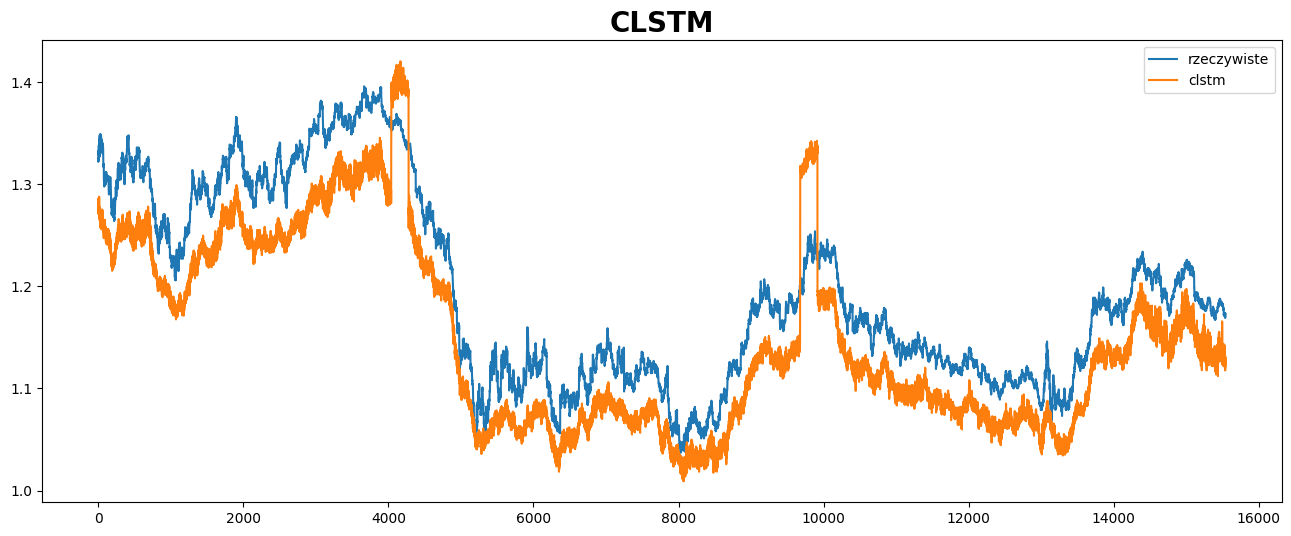

In [5]:
x = train_y.index[-len(pred):]

lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(range(len(pred)), train_y[240:], label="rzeczywiste", title="CLSTM")
lp.plot(range(len(pred)), pred, label="clstm")